<a href="https://colab.research.google.com/github/davidgonmar/model-compression-exps/blob/main/energy_vs_loss_perturbation_svd_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from tqdm import tqdm
import seaborn as sns

In [14]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset & Augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load dataset
batch_size = 128
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Model Setup
model = resnet18(num_classes=10).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for better generalization
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Train Model for a few epochs
num_epochs = 5  # Reduce for quick experimentation
print("Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


orig_model = model

Training...


100%|██████████| 391/391 [00:09<00:00, 39.45it/s]


Epoch 1, Loss: 1.4934


100%|██████████| 391/391 [00:09<00:00, 39.84it/s]


Epoch 2, Loss: 1.3713


100%|██████████| 391/391 [00:10<00:00, 38.39it/s]


Epoch 3, Loss: 1.3245


100%|██████████| 391/391 [00:10<00:00, 36.05it/s]


Epoch 4, Loss: 1.0854


100%|██████████| 391/391 [00:09<00:00, 39.97it/s]

Epoch 5, Loss: 0.9641


Baseline Loss: 1.2465
Running SVD analysis...


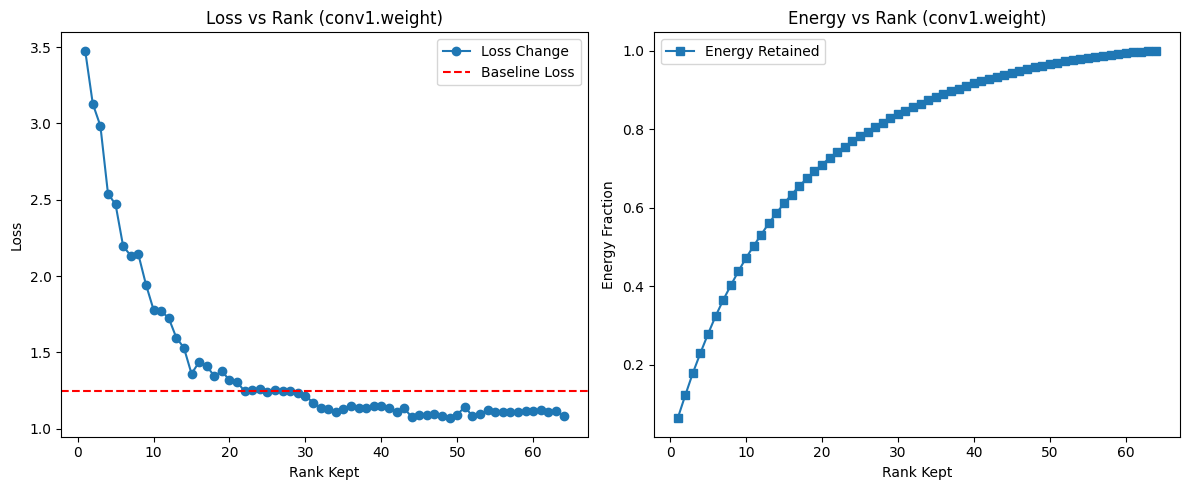

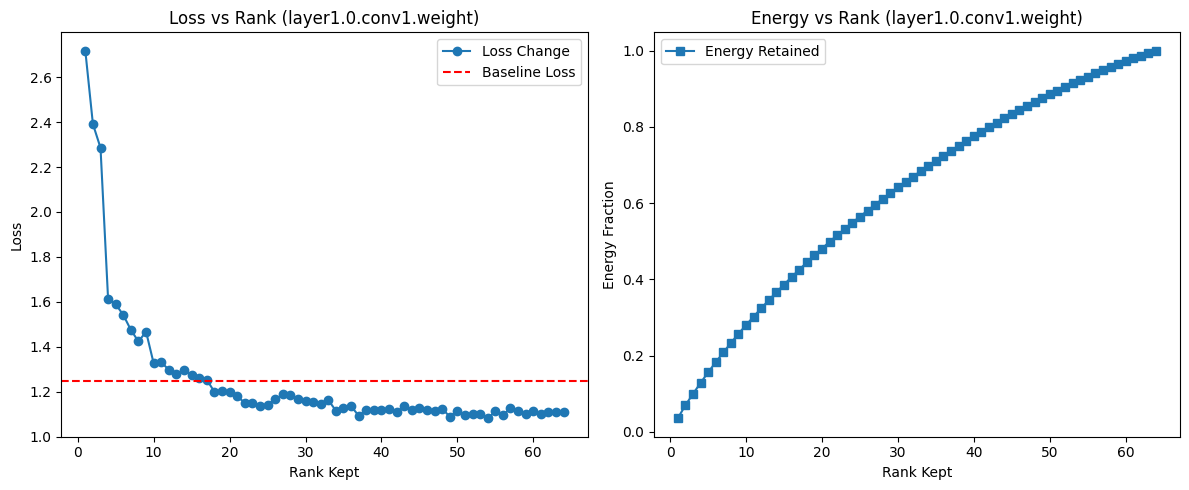

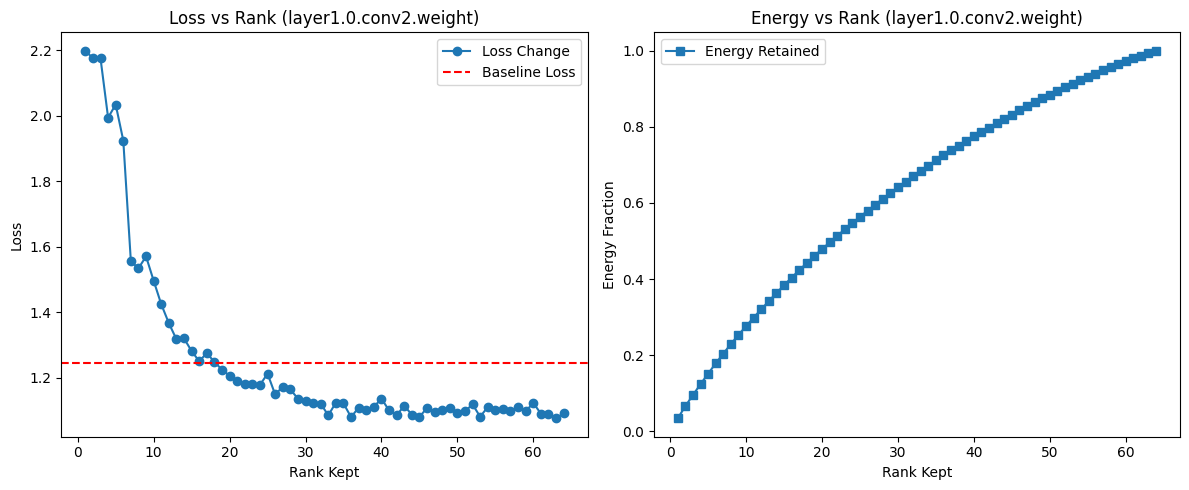

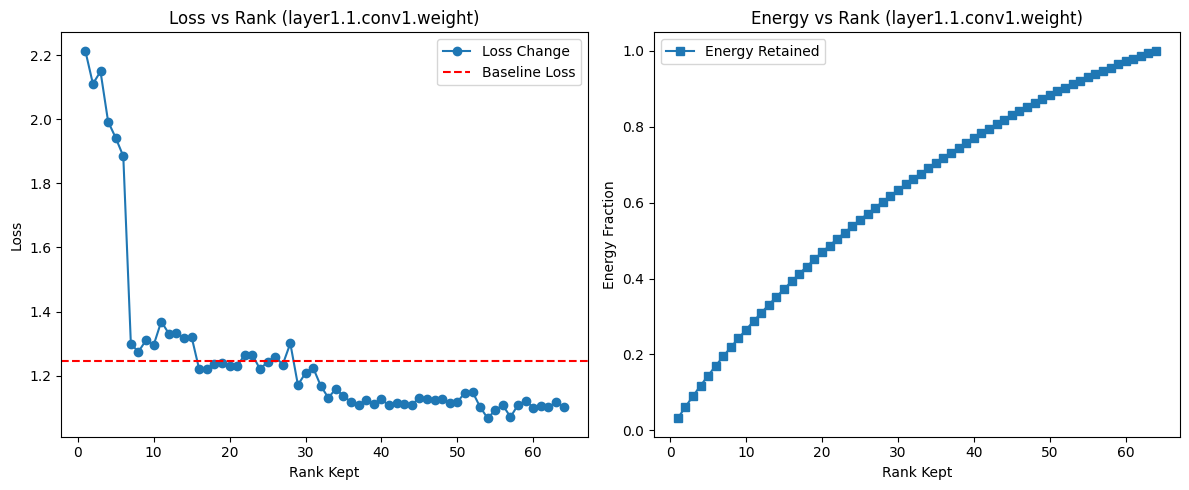

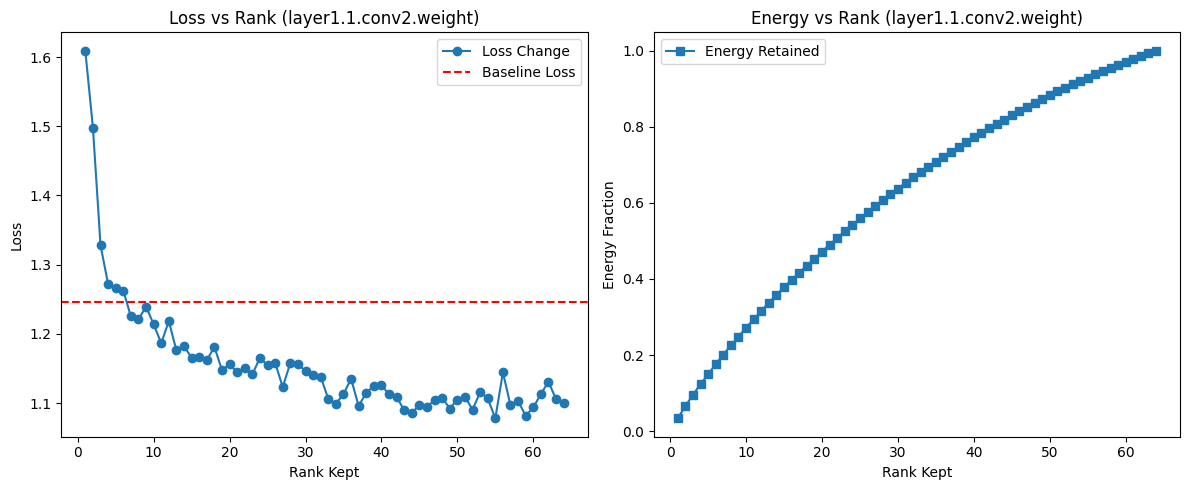

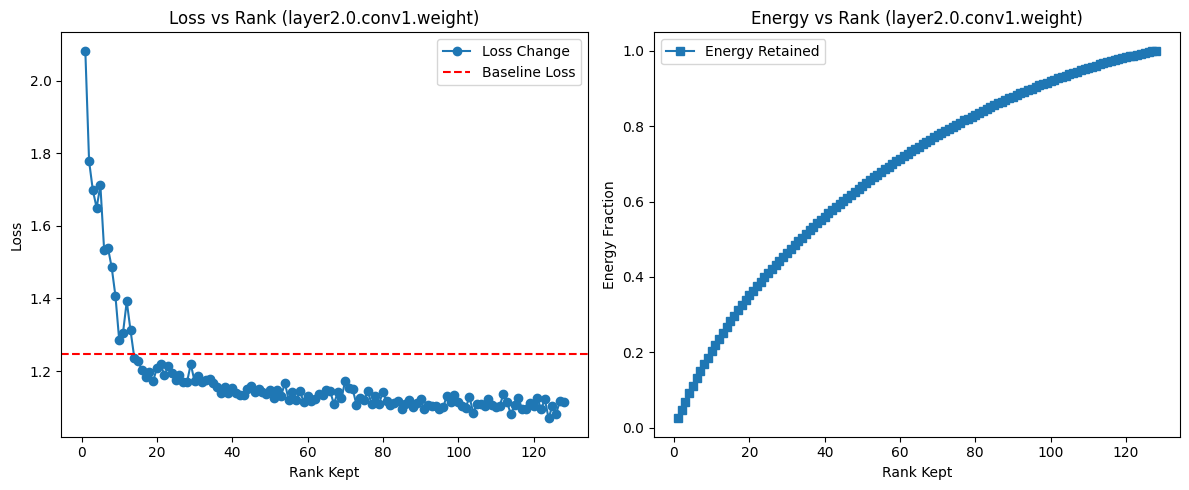

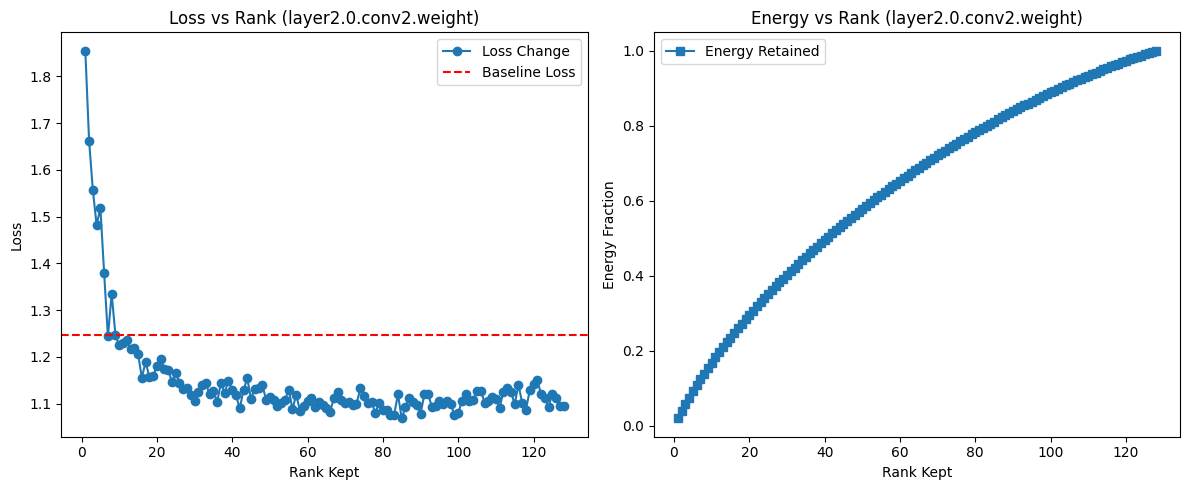

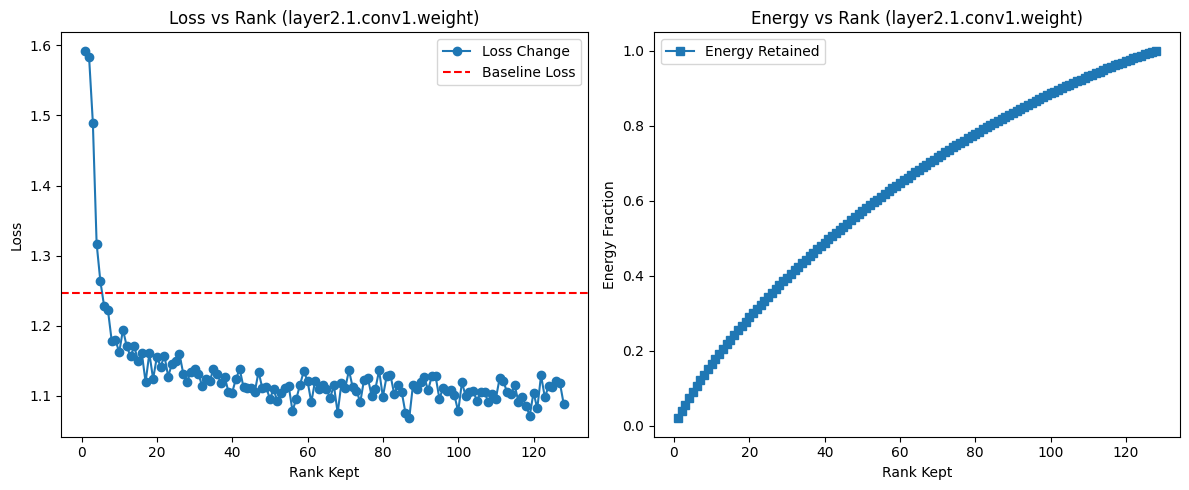

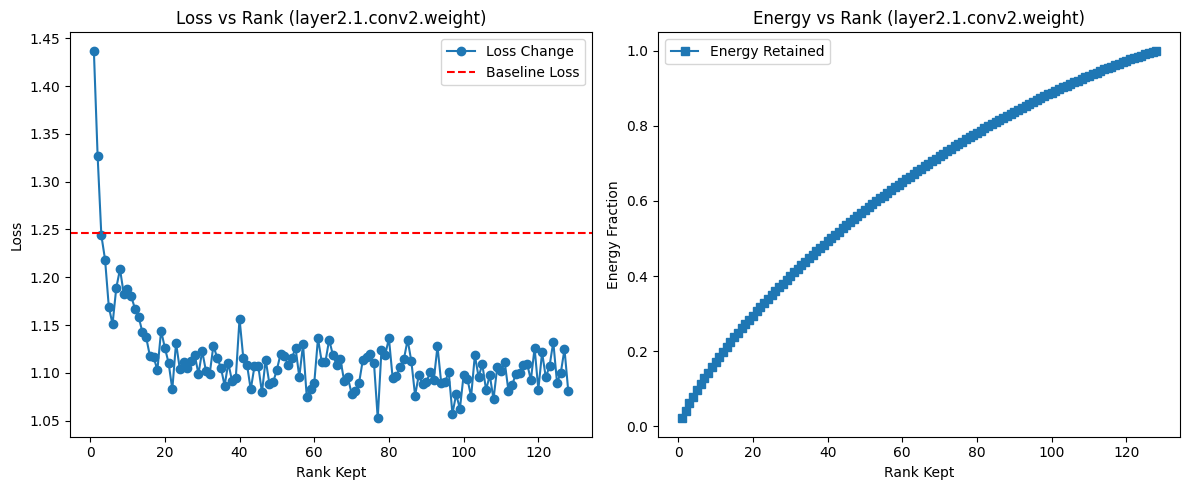

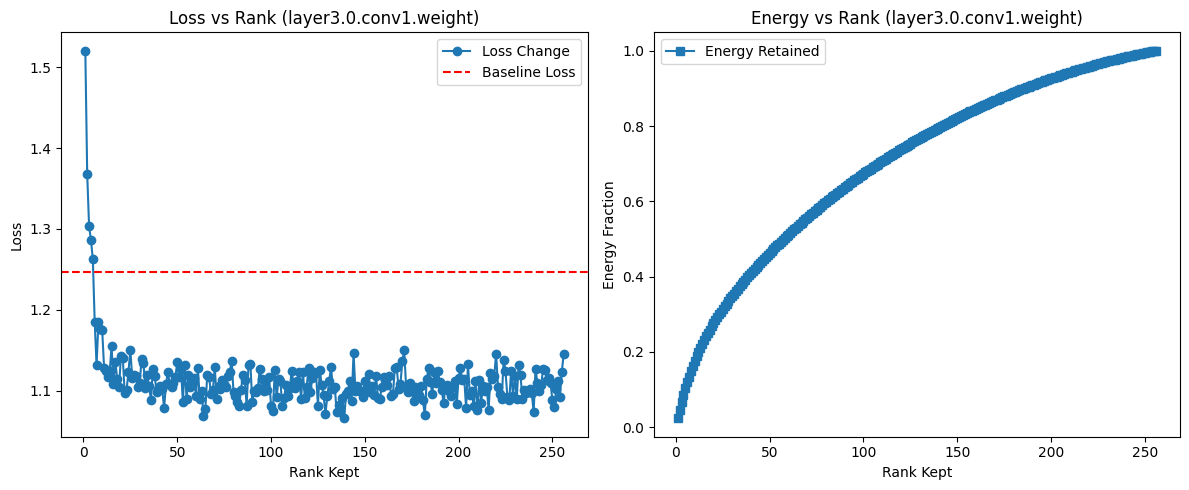

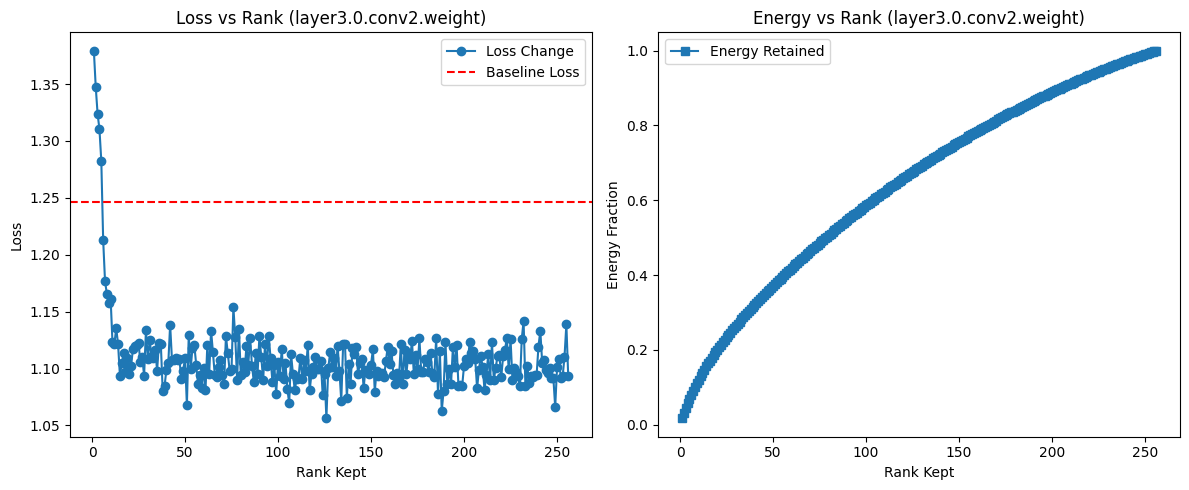

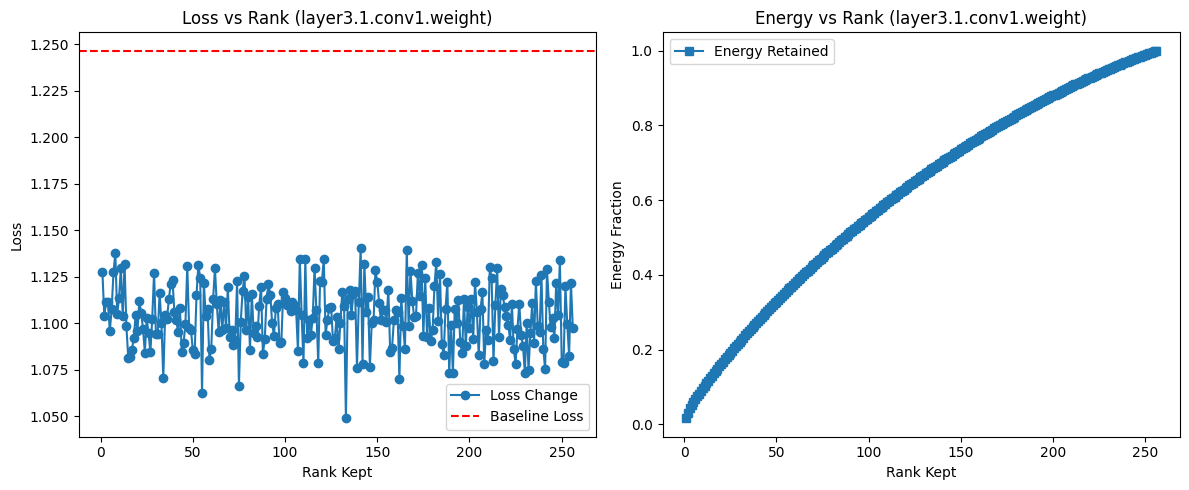

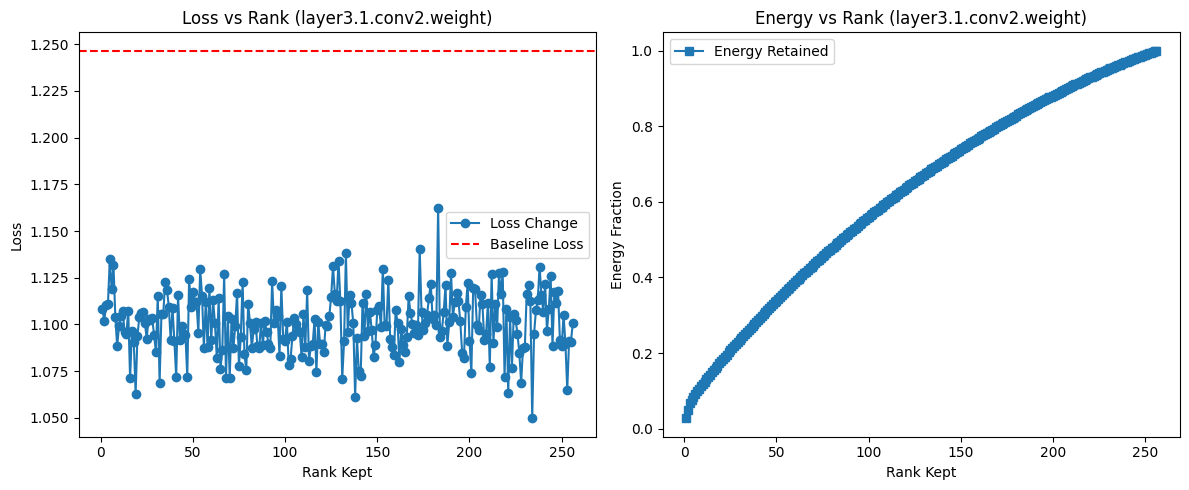

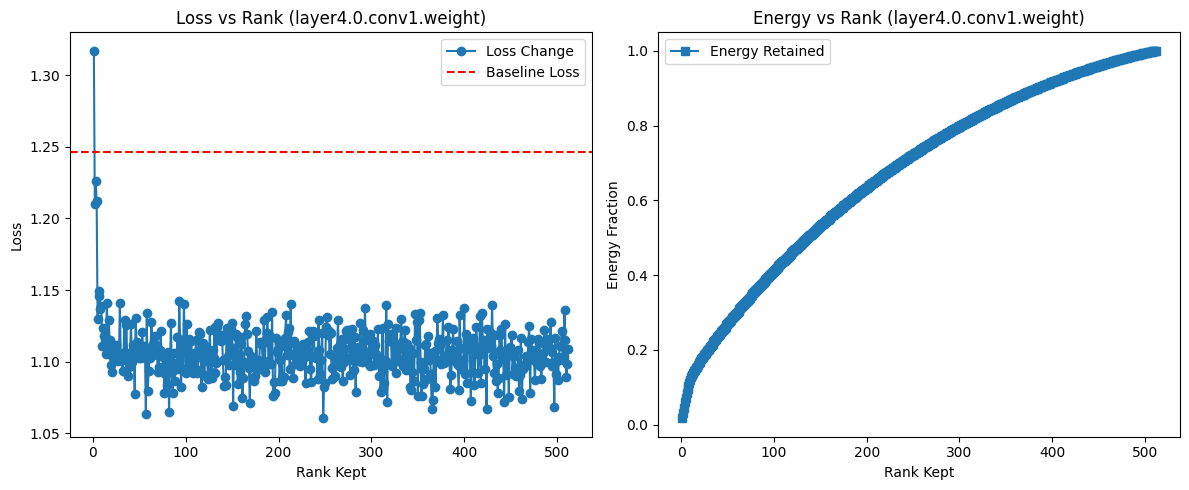

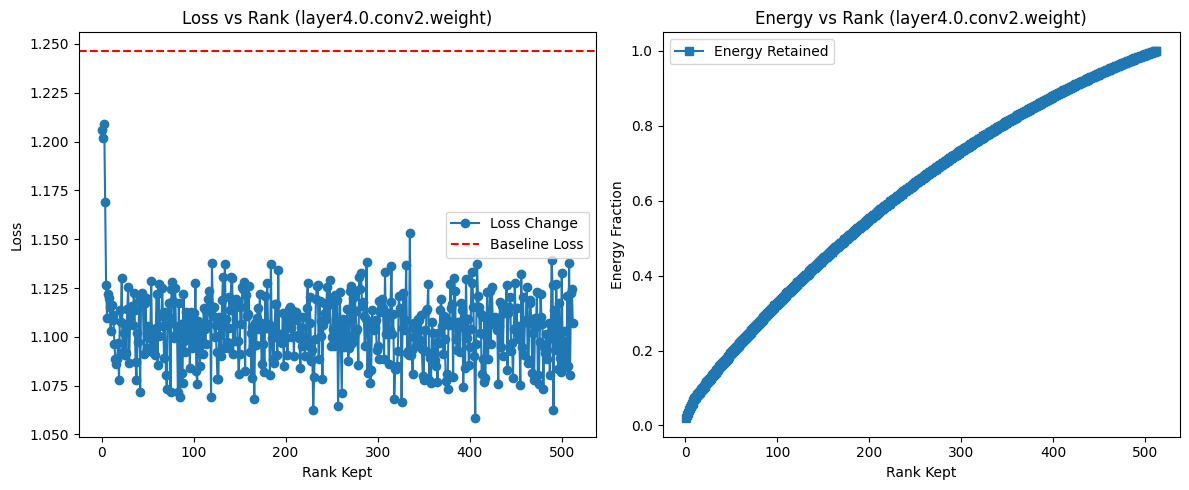

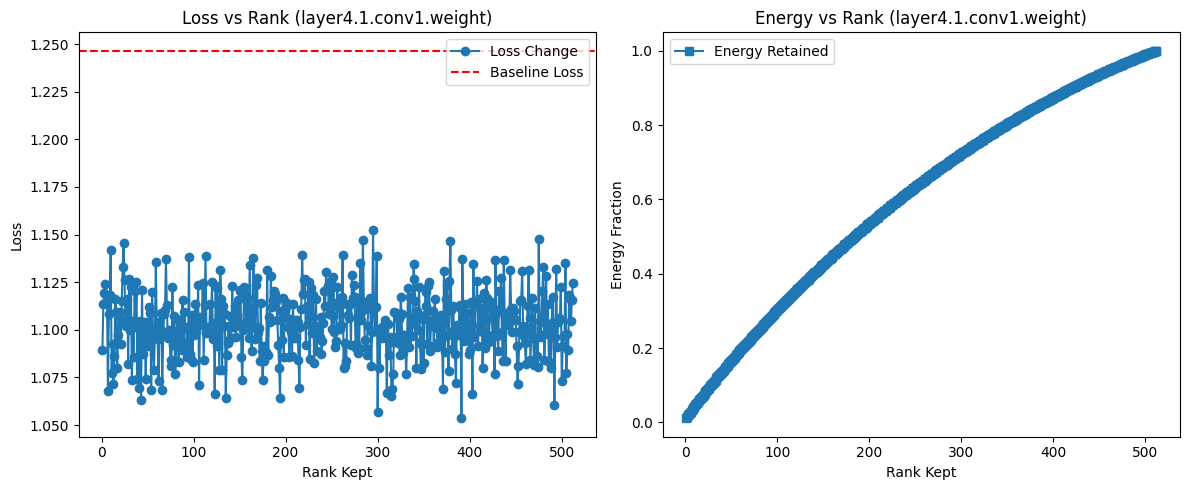

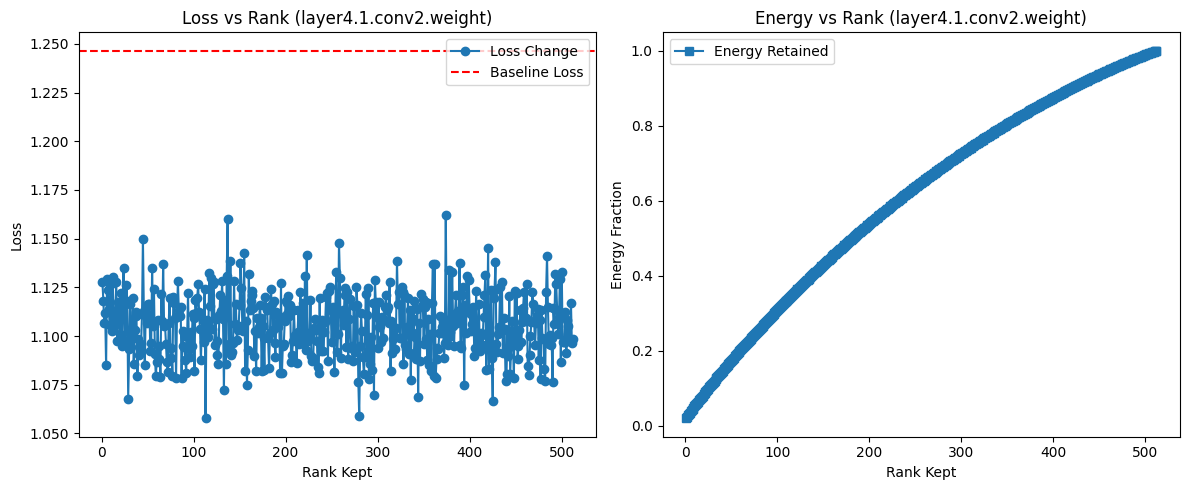

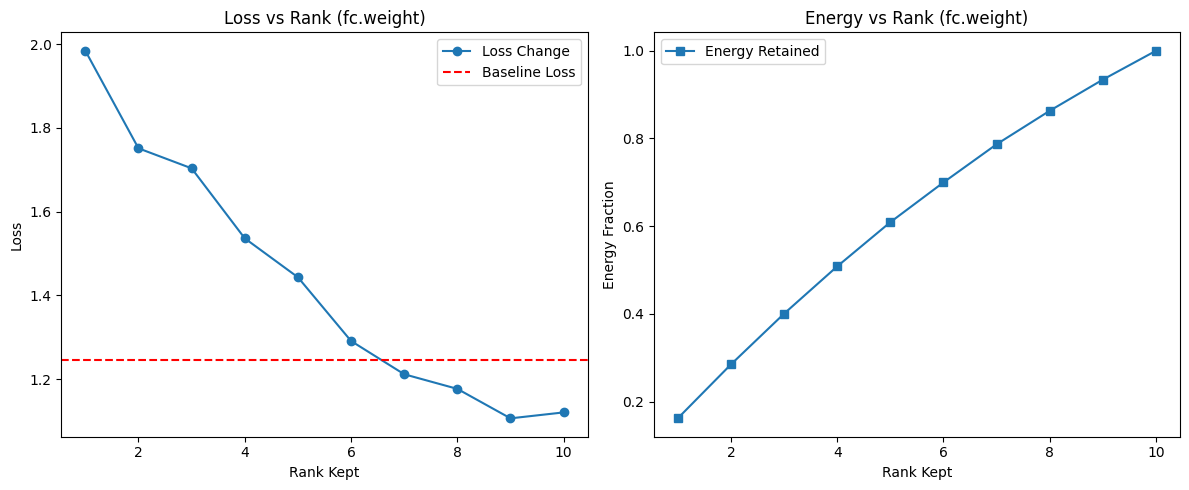

In [18]:
# Select a random subset of training data
import copy
subset_size = 500
train_subset, _ = random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
subset_loader = DataLoader(train_subset, batch_size=500, shuffle=False)
model = copy.deepcopy(orig_model)

# Function to compute loss on a dataset
@torch.no_grad()
def compute_loss(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
    return total_loss / len(data_loader.dataset)

# Baseline Loss
baseline_loss = compute_loss(model, subset_loader, criterion)
print(f"Baseline Loss: {baseline_loss:.4f}")

# Function to compute loss perturbation when removing singular values
def svd_pruning_analysis(model, data_loader, criterion):
    layer_results = {}

    for name, param in model.named_parameters():
        if 'weight' in name and ('conv' in name or 'fc' in name):
            print(name)
            weight = param.detach()
            original_shape = weight.shape

            # Reshape conv layers to (C_out, -1)
            if len(weight.shape) == 4:  # Conv layer (C_out, C_in, H, W)
                weight = weight.reshape(weight.shape[0], -1)

            # Compute SVD using PyTorch
            U, S, Vt = torch.svd(weight)
            total_energy = torch.sum(S**2)

            losses = []
            energies = []

            # Try removing up to each rank
            for r in range(1, len(S) + 1):
                Sr = torch.zeros_like(S)
                Sr[:r] = S[:r]  # Keep only top r singular values
                W_r = (U * Sr) @ Vt.T

                # Reshape back if it was a conv layer
                if len(original_shape) == 4:
                    W_r = W_r.reshape(original_shape)

                # Replace the weight temporarily
                param.data = W_r.to(device)

                # Compute loss
                loss = compute_loss(model, data_loader, criterion)
                losses.append(loss.detach().cpu())
                energies.append((torch.sum(Sr**2) / total_energy).detach().cpu())  # Energy retained
                param.data = weight.reshape(original_shape)

            # Store results
            layer_results[name] = (losses, energies)
    return layer_results

# Run SVD pruning analysis
print("Running SVD analysis...")
layer_results = svd_pruning_analysis(model, subset_loader, criterion)

# Plot Results
for layer_name, (losses, energies) in layer_results.items():
    ranks = np.arange(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss vs. Rank
    plt.subplot(1, 2, 1)
    plt.plot(ranks, [loss.detach().cpu() for loss in losses], label="Loss Change", marker='o')
    plt.axhline(y=baseline_loss, color='r', linestyle='--', label="Baseline Loss")
    plt.xlabel("Rank Kept")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Rank ({layer_name})")
    plt.legend()

    # Energy vs. Rank
    plt.subplot(1, 2, 2)
    plt.plot(ranks, [e.detach().cpu() for e in energies], label="Energy Retained", marker='s')
    plt.xlabel("Rank Kept")
    plt.ylabel("Energy Fraction")
    plt.title(f"Energy vs Rank ({layer_name})")
    plt.legend()

    plt.tight_layout()
    plt.show()
